## Data preparation

### Raw data

In [70]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import visuals as vs
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

df = pd.read_csv('.\\data\\orderWithProfit.csv', header=0)
# filtered_df = df[df['orderdate'].isnull()]
df = df.dropna()
df["orderDate"] = df["orderDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["takenDate"] = df["takenDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["shipDate"] = df["shipDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["transitDuration"] = (df["shipDate"]-df["takenDate"])/ np.timedelta64(1, 's')
df["fulfillDuration"] = (df["shipDate"]-df["orderDate"])/ np.timedelta64(1, 's')

df["amount"] = df["red"]+df["blue"]+df["yellow"]+df["black"]+df["white"]

## Add Customer ID (Integer number)
customer_dic= {}
id = 1
for _,name in df[["customer"]].drop_duplicates()["customer"].iteritems():
    customer_dic[name] = id # id starts from 0
    id = id+1
    
df["customer_id"] = df["customer"].apply(lambda x: customer_dic[x])

index = ["customer_id", "customer","amount","green","blue","black","yellow","red","white",\
         "orderDate","takenDate","shipDate","transitDuration","fulfillDuration","shipVisitCount",\
         "shipHandleCost", "productSales","totalRevenue","productCOGS","orderProcessCost","shipVisitCost","totalCost","profit"]
df = df[index]
df.head()

,customer_id,customer,amount,green,blue,black,yellow,red,white,orderDate,...,fulfillDuration,shipVisitCount,shipHandleCost,productSales,totalRevenue,productCOGS,orderProcessCost,shipVisitCost,totalCost,profit
0,1,Sherrie,26,7,3,6,8,9,0,2018-06-18 16:08:37,...,229,2,10.0,118,128.0,73.88,10,13.750000,107.630000,20.370000
1,2,Dan,31,5,2,8,1,10,10,2018-06-18 16:08:37,...,333,2,10.0,119,129.0,74.48,10,15.000000,109.480000,19.520000
2,3,Erma,25,6,6,2,8,1,8,2018-06-18 16:08:37,...,505,3,9.5,95,104.5,59.46,10,12.916667,91.876667,12.623333
3,4,Sharon,33,4,8,9,9,5,2,2018-06-18 16:08:37,...,584,2,10.0,131,141.0,82.03,10,15.416667,117.446667,23.553333
4,1,Sherrie,18,3,3,1,0,6,8,2018-06-18 16:08:37,...,636,2,6.0,60,66.0,37.55,10,8.750000,62.300000,3.700000


### Features

#### Order
customer

green,blue,black,yellow,red,white

**amount** = green + blue + black + yellow + red + white

#### Duration

orderDate,takenDate,shipDate

**transitDuration** = shipDate - takenDate

**fufillDuration** = shipDate - orderDate

shipVisitCount

#### Cost, revenue, profit
productSales,shipHandleCost

**totalRevenue**=productSales + shipHandleCost

productCOGS, *orderProcessCost(=10)*, shipVisitCost

**totalCost** = productCOGS + *orderProcessCost* + shipVisitcCost

**profit**= **totalRevenue** - **totalCost**

### PCA

In [71]:
X = {}
index = {}

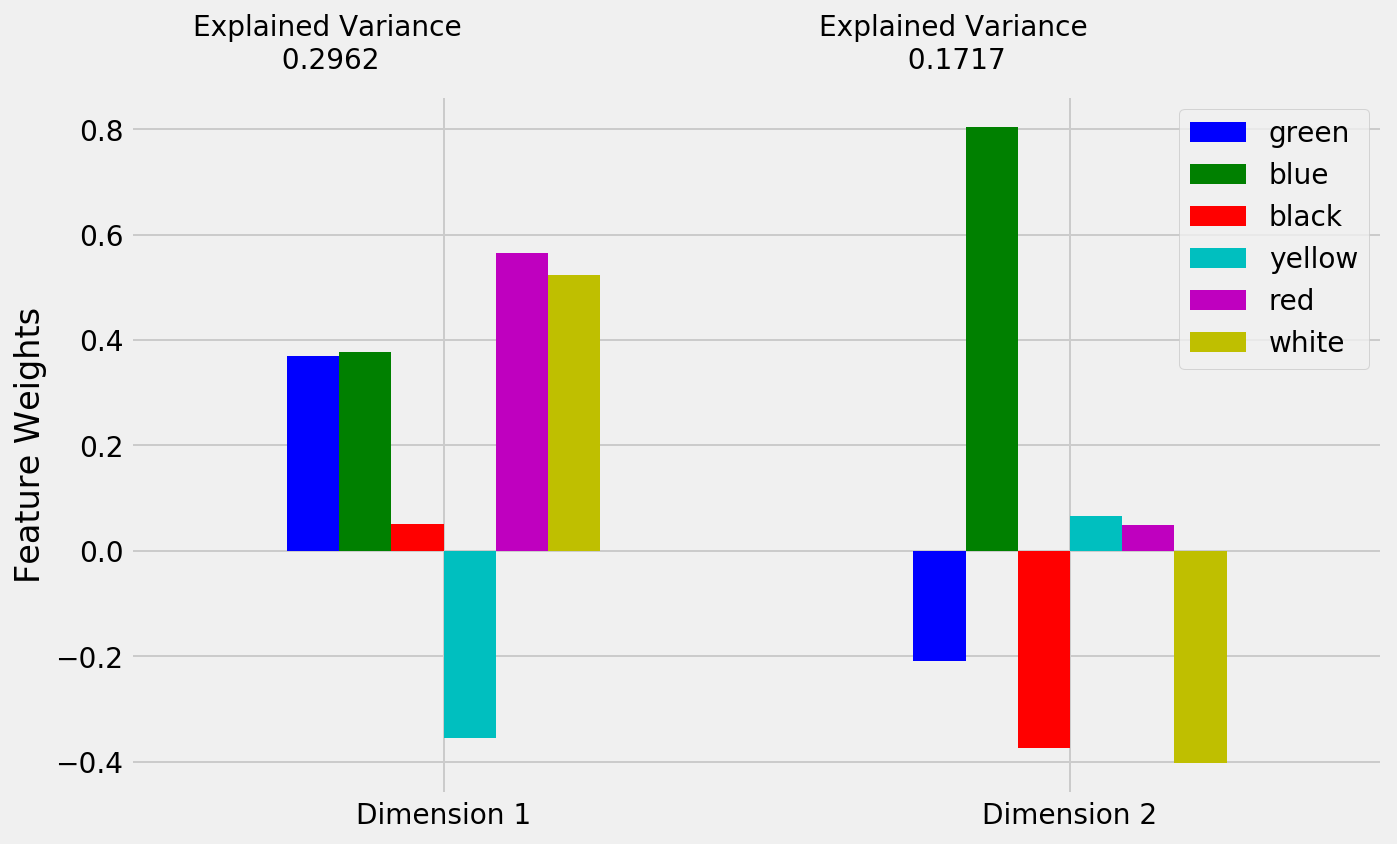

In [72]:
from sklearn.decomposition import PCA
index[0]=["green","blue", "black", "yellow","red","white"]
X[0] = df[index[0]]

pca = PCA(n_components=2)
X[0] = pca.fit_transform(X[0])

pca_results = vs.pca_results(df[index[0]], pca)

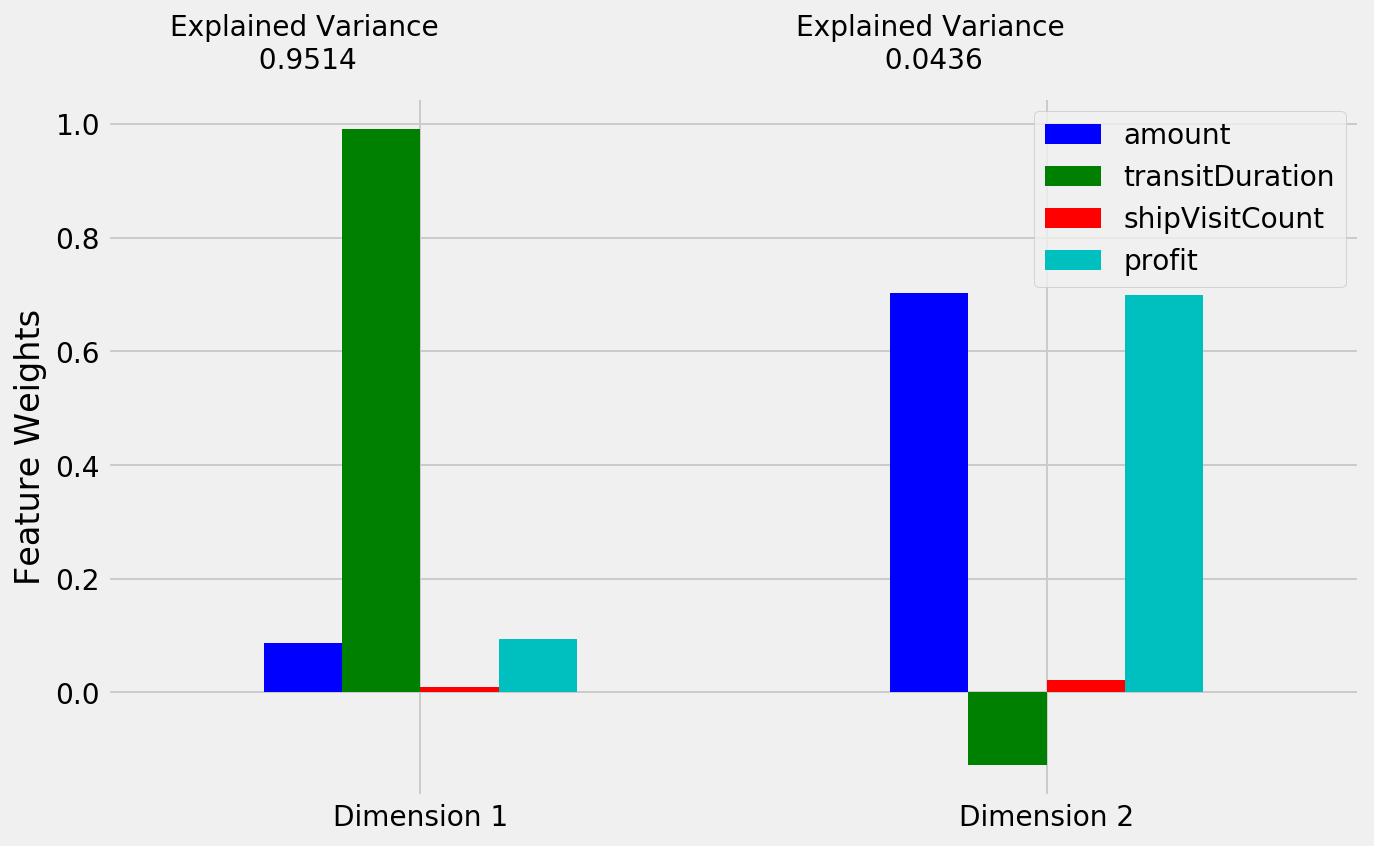

In [73]:
from sklearn.decomposition import PCA
index[1]=["amount","transitDuration", "shipVisitCount", "profit"]
X[1] = df[index[1]]

pca = PCA(n_components=2)
X[1] = pca.fit_transform(X[1])

pca_results = vs.pca_results(df[index[1]], pca)

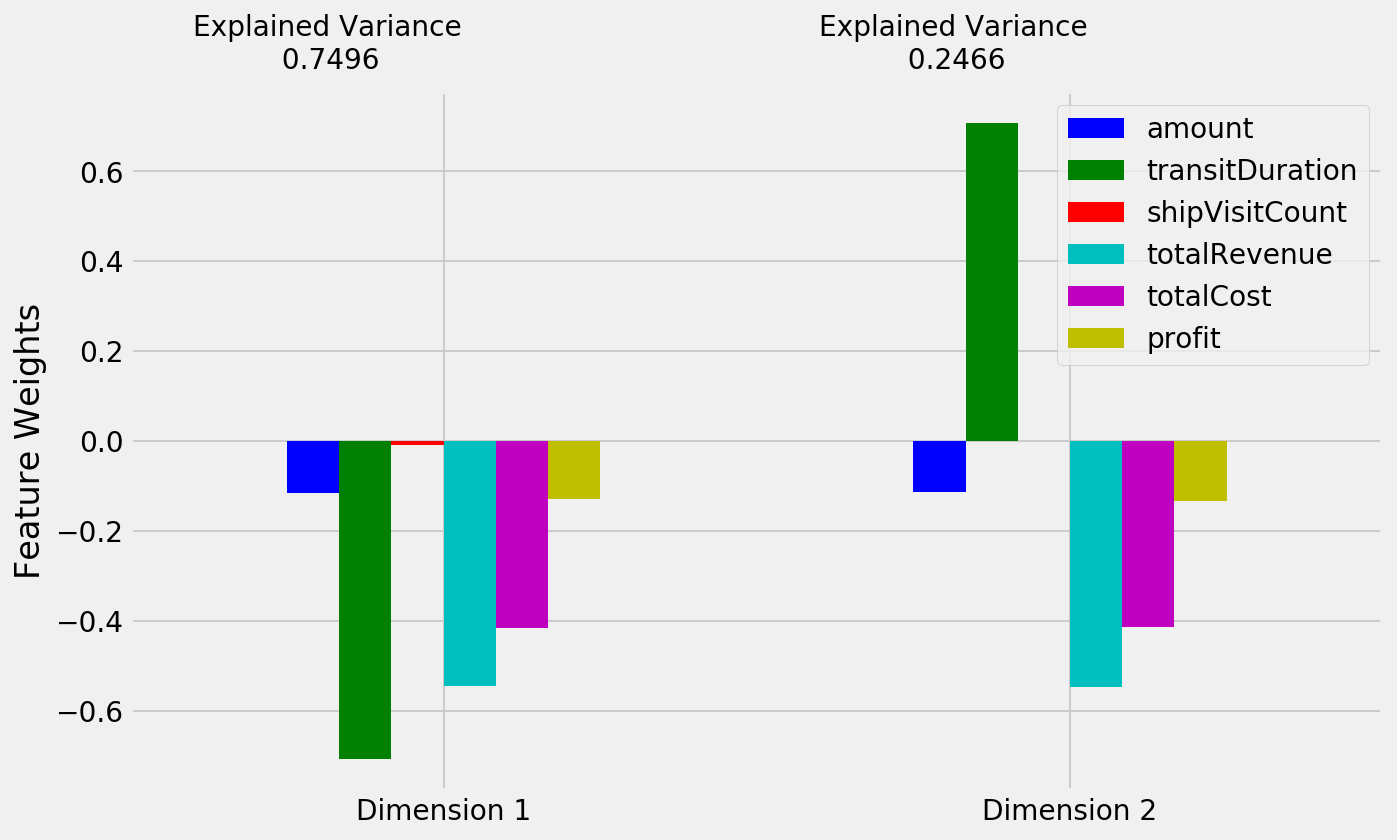

In [74]:
from sklearn.decomposition import PCA
index[2]=["amount","transitDuration", "shipVisitCount", "totalRevenue","totalCost","profit"]
X[2] = df[index[2]]

pca = PCA(n_components=2)
X[2] = pca.fit_transform(X[2])

pca_results = vs.pca_results(df[index[2]], pca)

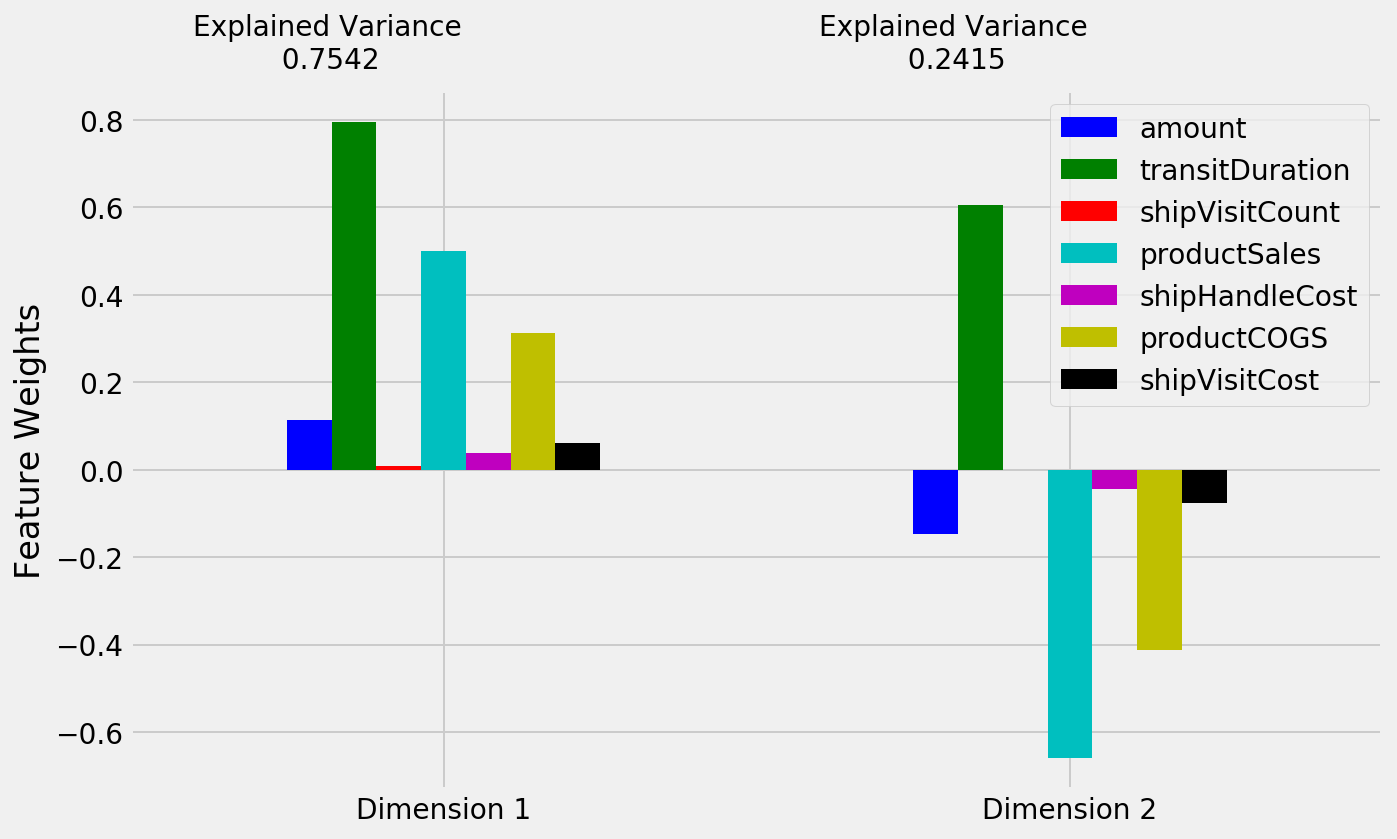

In [75]:
from sklearn.decomposition import PCA
index[3]=["amount","transitDuration", "shipVisitCount", "productSales",\
        "shipHandleCost","productCOGS","shipVisitCost"]
X[3] = df[index[3]]

pca = PCA(n_components=2)
X[3] = pca.fit_transform(X[3])

pca_results = vs.pca_results(df[index[3]], pca)

### Feature Selection

SSH and C&H scores conflict, choose C&H result: dataset index # 1


<Figure size 720x1440 with 0 Axes>

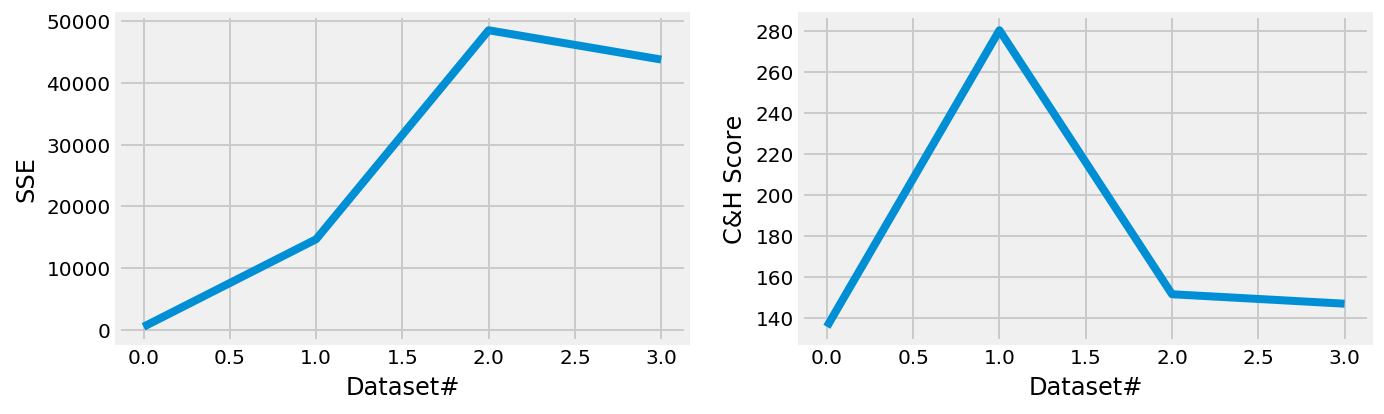

In [76]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np

sse = {}
chs = {}
fig = plt.figure(1, figsize=(10,20))
for i in xrange(4):
    #KMeans    
    km = KMeans(n_clusters=9,
               max_iter=2000)

    y_pred = km.fit_predict(X[i])
    
    #Measuremenet: SSE
    sse[i] = km.inertia_
    #Measuremenet: Calinski and Harabaz score
    chs[i]= calinski_harabaz_score(X[i], y_pred)

#Plotting SSE
fig = plt.figure(2,figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Dataset#")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Dataset#")
plt.ylabel("C&H Score")

# Chooose the best dataset index
i_sse = max(sse.items(), key = lambda x:x[1])[0]
i_chs = max(chs.items(), key = lambda x:x[1])[0]
INDEX = i_chs
if i_sse == i_chs:
    print "SSH and C&H scores agree on dataset index #",INDEX
else:
    print "SSH and C&H scores conflict, choose C&H result: dataset index #",INDEX

### PCA Analysis

## K-Means

### SSE change with K

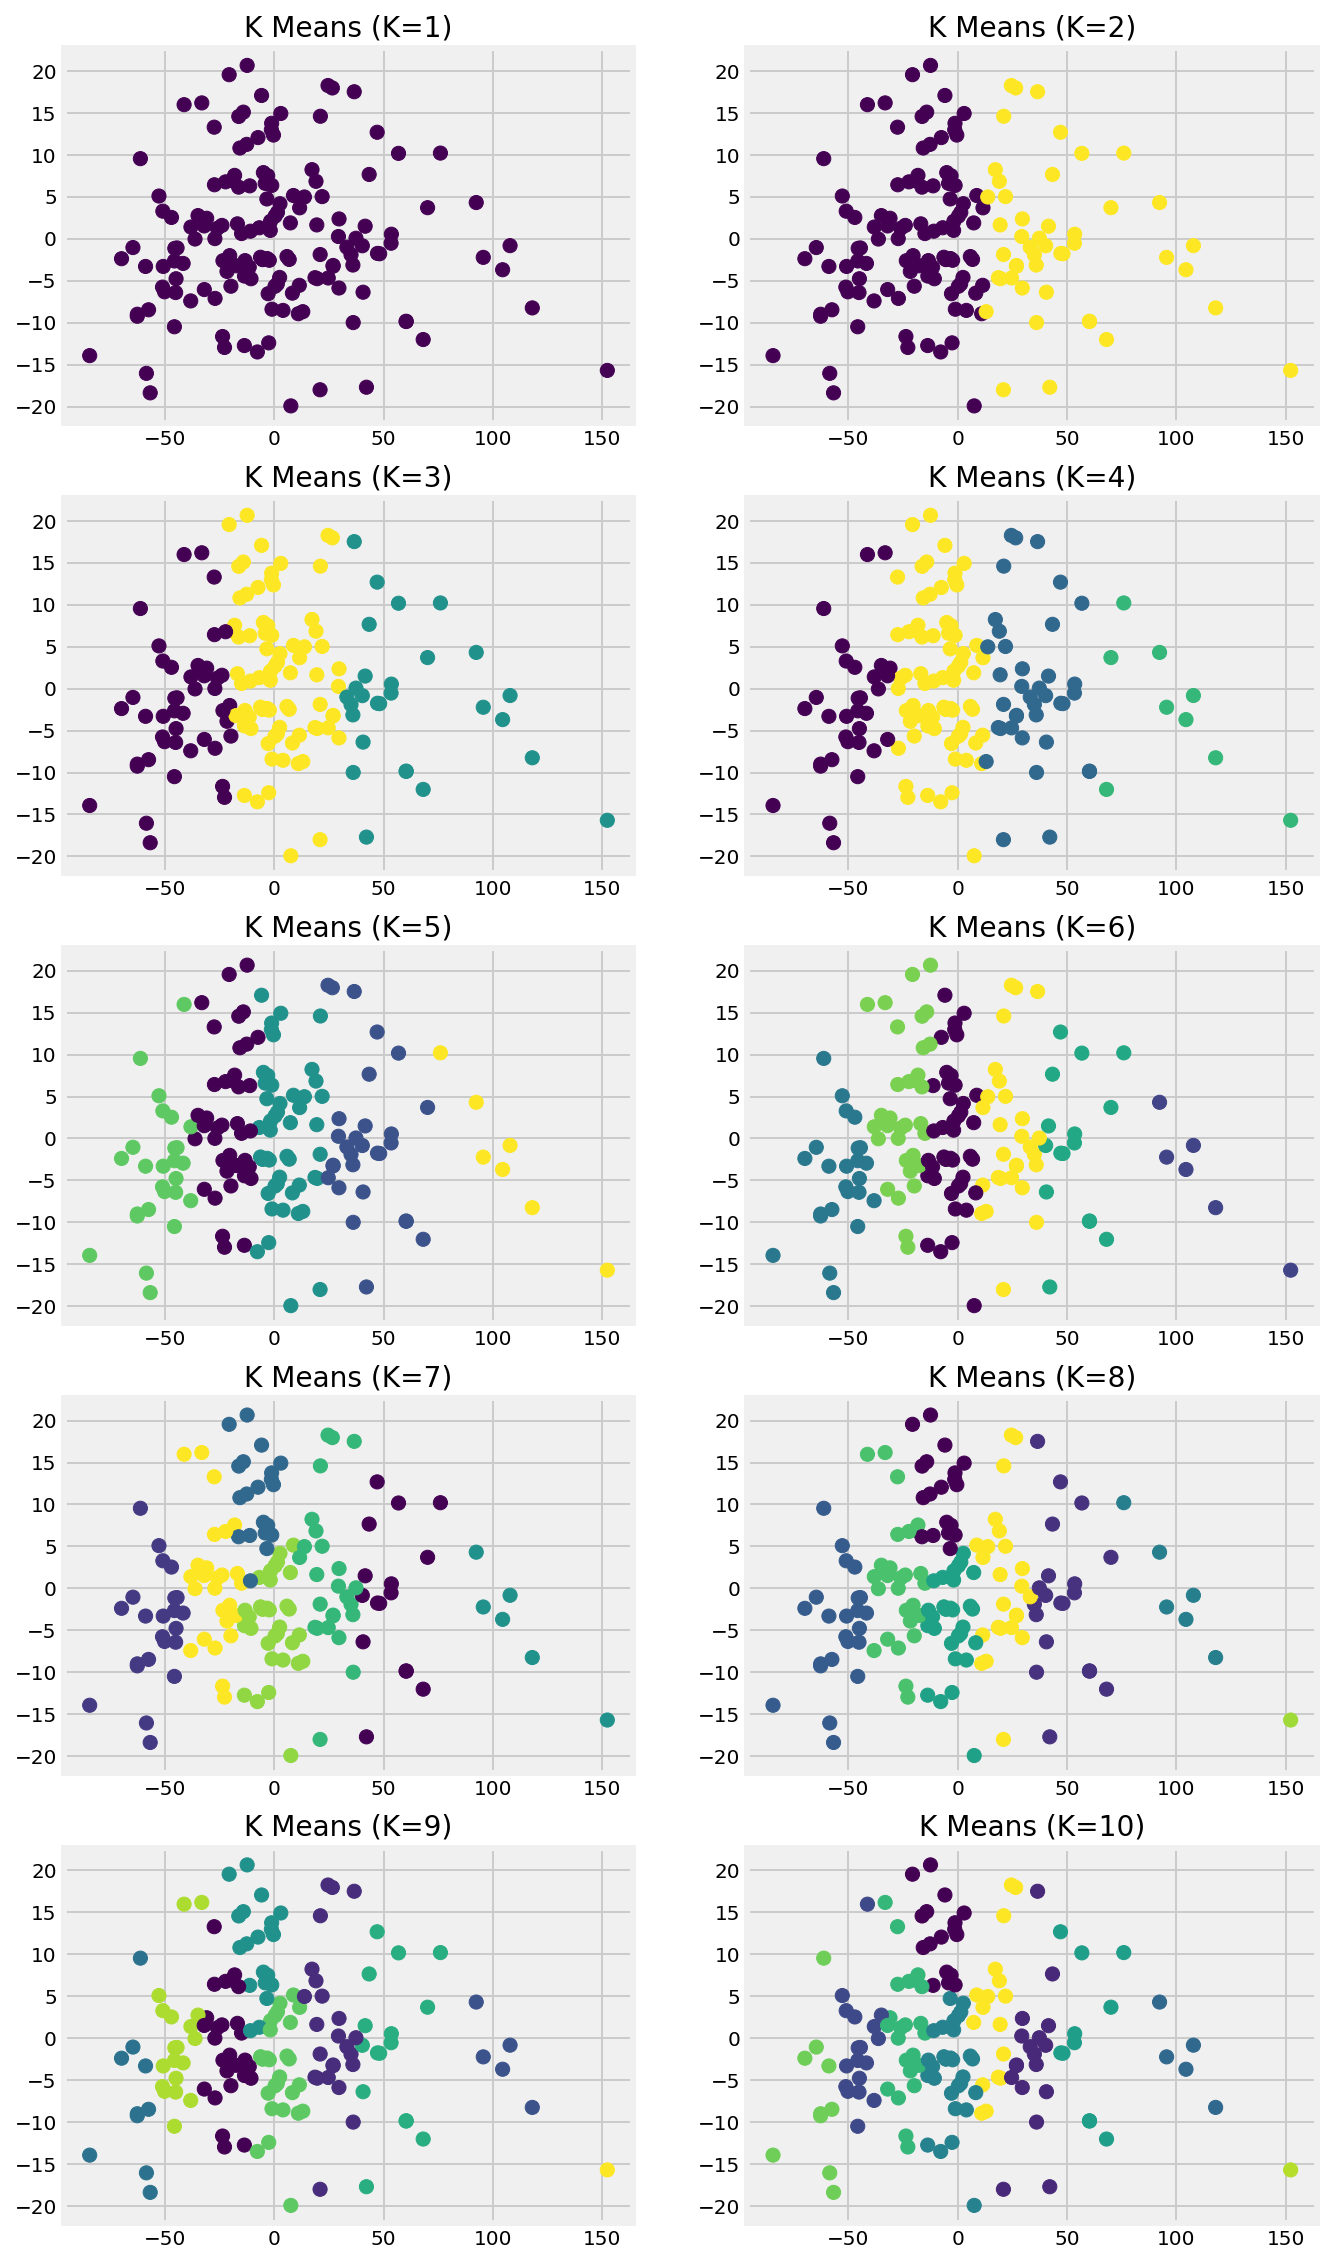

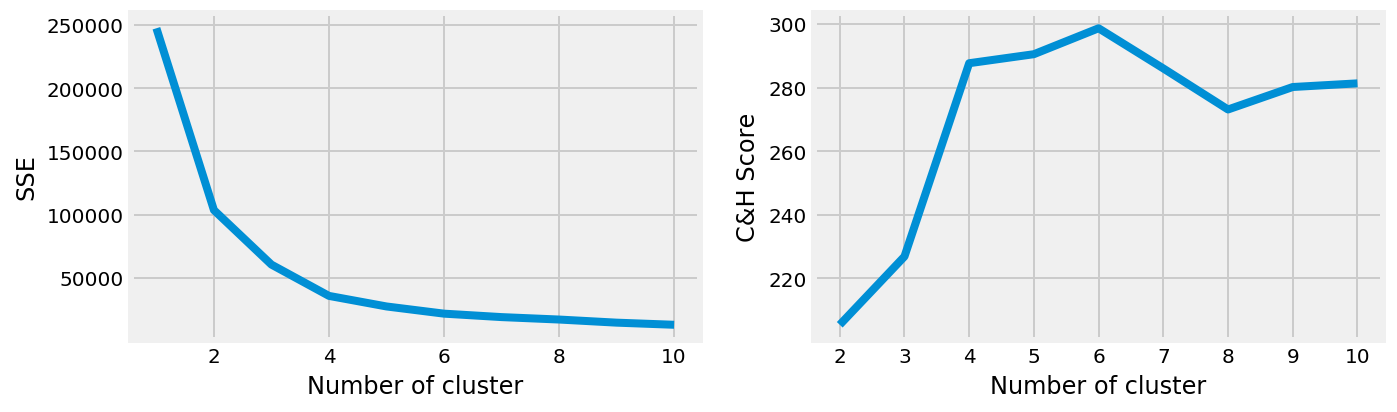

In [77]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np

data = X[INDEX]

sse = {}
chs = {}
fig = plt.figure(1, figsize=(10,20))
for k in xrange(1,11):
    #KMeans    
    km = KMeans(n_clusters=k,
               max_iter=2000)

    y_pred = km.fit_predict(data)
    sse[k] = km.inertia_

    #Measuremenet: Calinski and Harabaz score
    if k!=1:
        chs[k]= calinski_harabaz_score(data, y_pred)
    
    plt.subplot(5,2,k)
    plt.scatter(data[:, 0], data[:, 1], c=y_pred, s=50, cmap='viridis')
    plt.title("K Means (K=%d)"%k, fontsize=14)

#Plotting SSE
fig = plt.figure(2,figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Number of cluster")
plt.ylabel("C&H Score")

# Chooose the best K
K = max(chs.items(), key = lambda x:x[1])[0]

### Cluster with best K

Calinski & Harabaz score: 299.2954806414192
SSE: 21719.213955654435


Text(0.5,1,'K Means (K=6)')

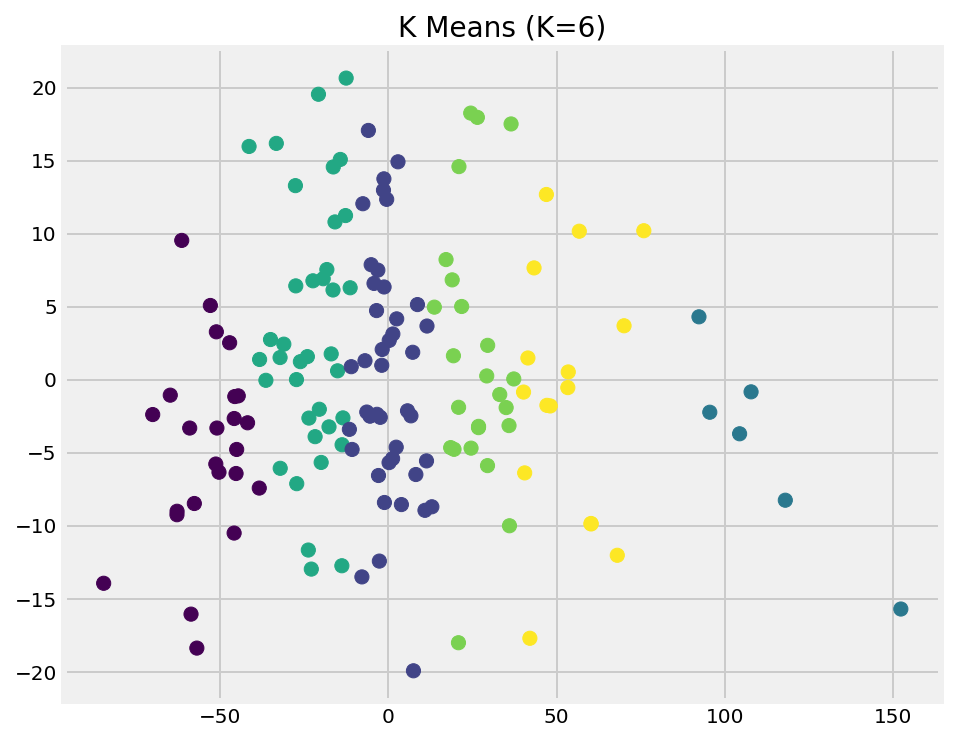

In [78]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np


#KMeans    
km = KMeans(n_clusters= K,
           max_iter=2000)

y_pred = km.fit_predict(data)

#Measuremenet: Calinski and Harabaz score
print "Calinski & Harabaz score:",calinski_harabaz_score(data, y_pred)  
print "SSE:",km.inertia_ 

#Plotting
fig = plt.figure(1, figsize=(7,6))
plt.scatter(data[:, 0], data[:, 1], c=y_pred, s=50, cmap='viridis')
plt.title("K Means (K=%d)"%K, fontsize=14)

### Examine clustered data

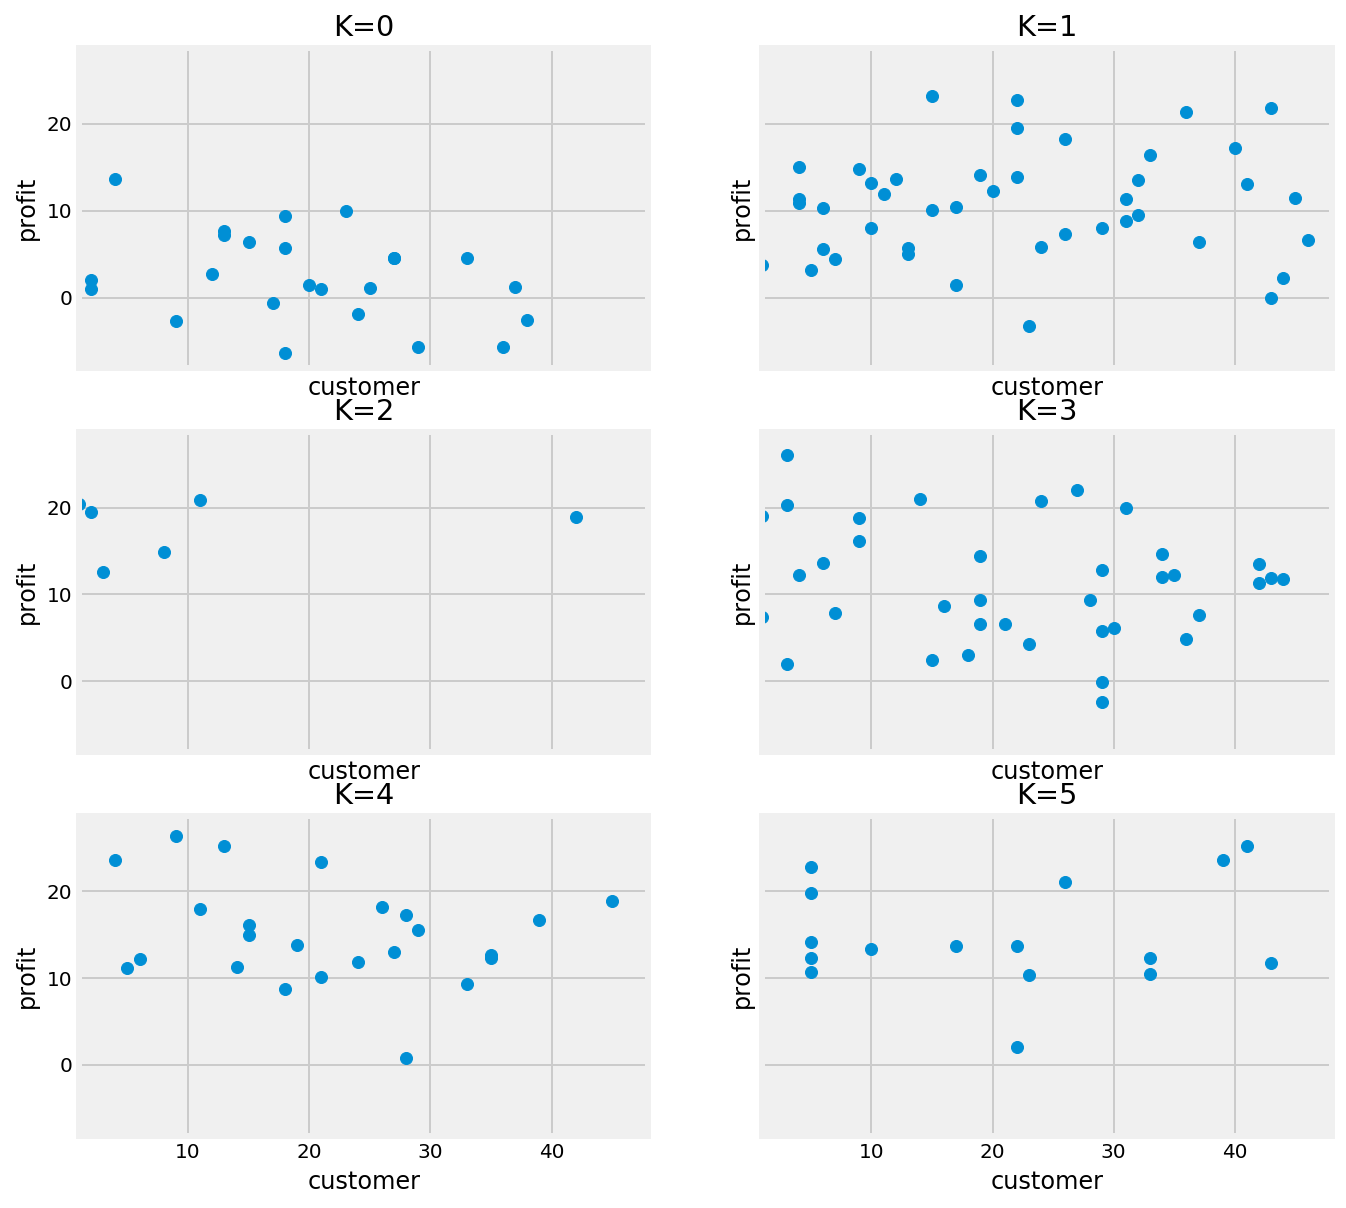

In [91]:
cluster = {}
fig, axes = plt.subplots(3,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["customer_id"],cluster[k]["profit"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('customer')
    ax.set_ylabel('profit')
    ax.set_title('K=%d'%k)

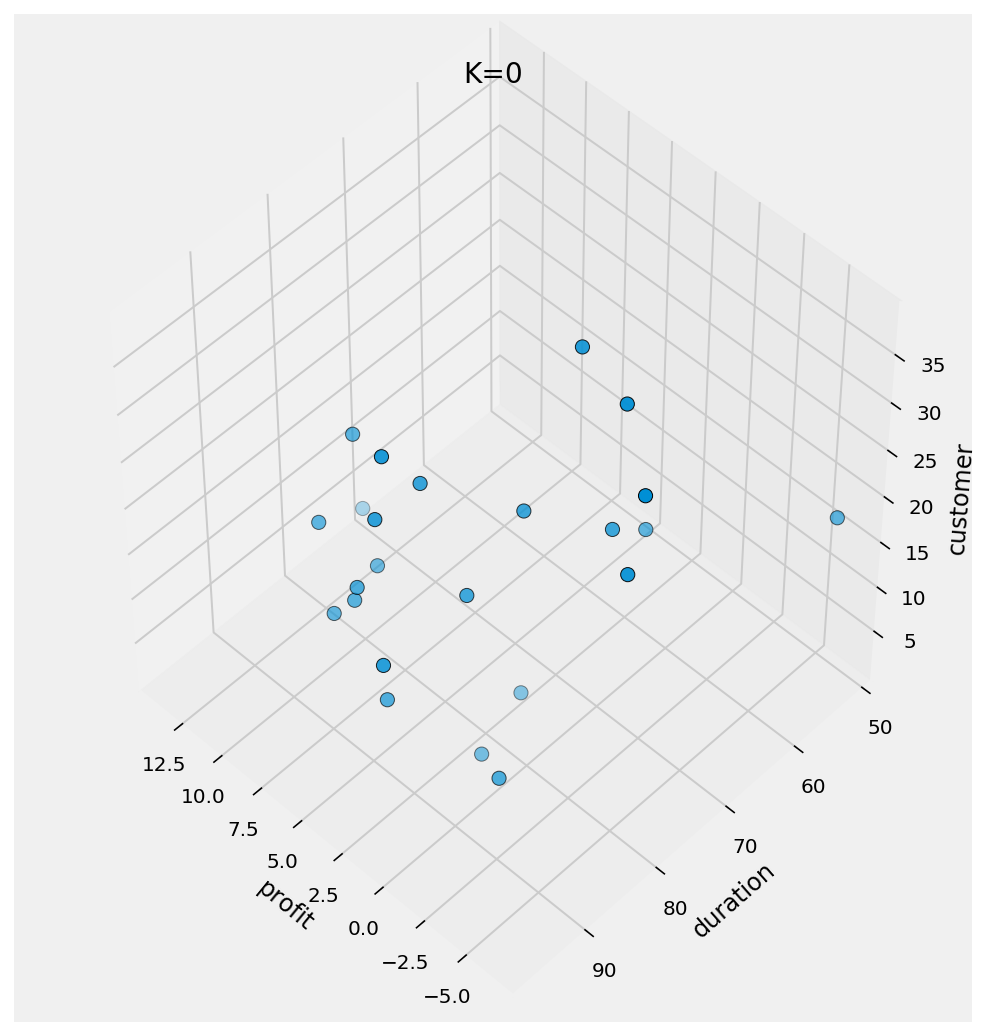

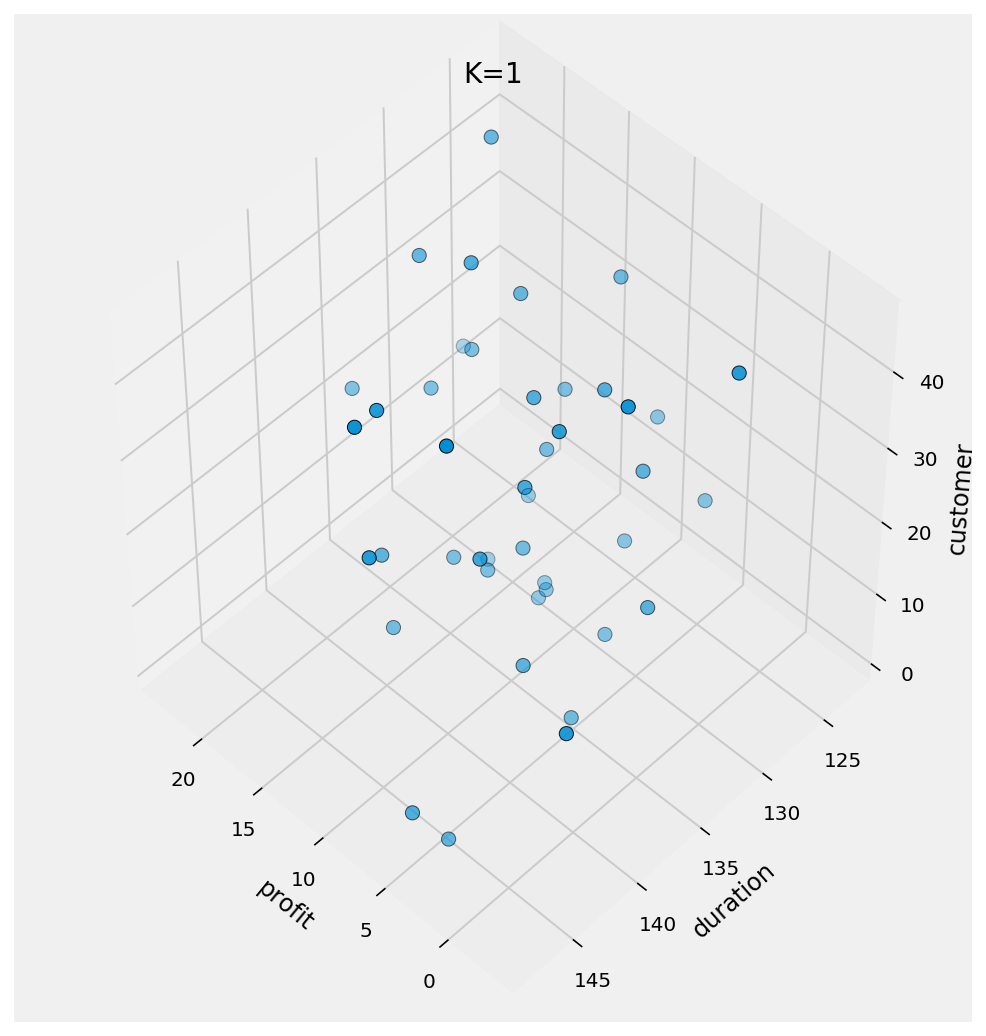

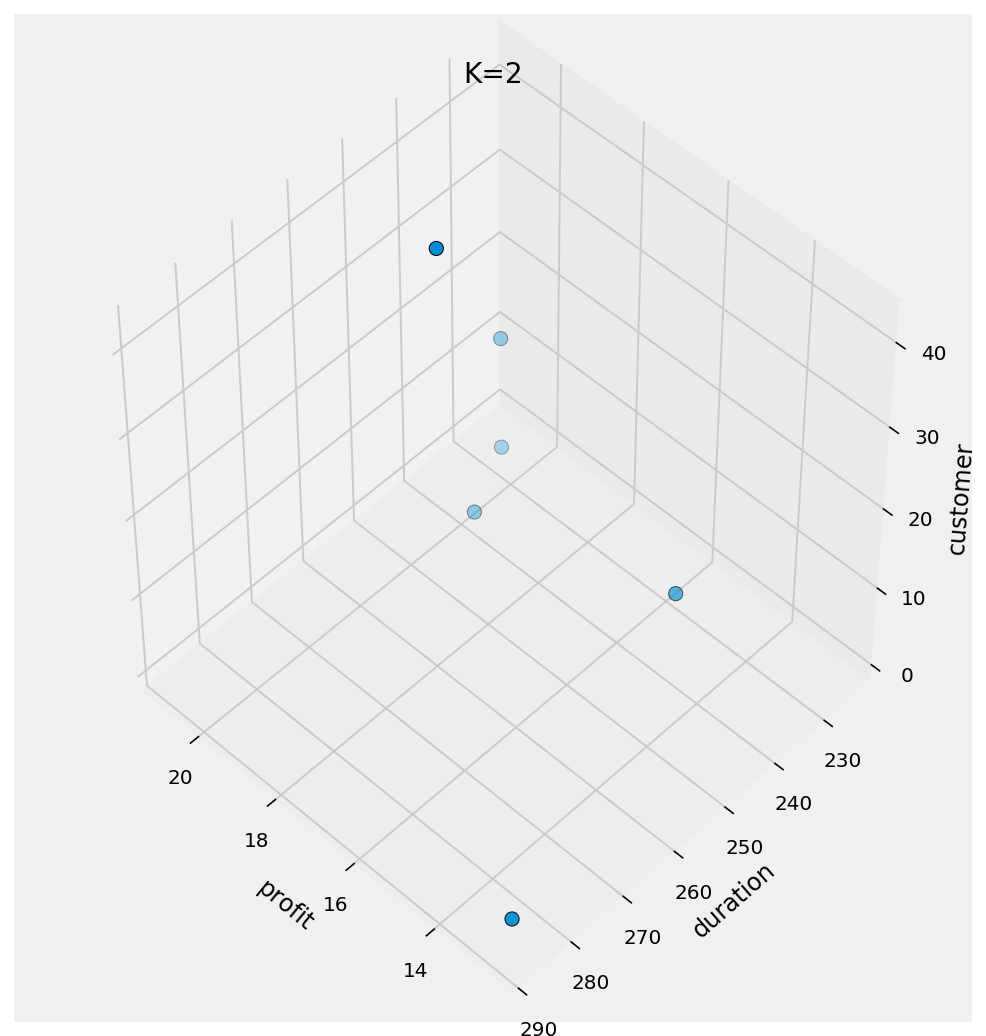

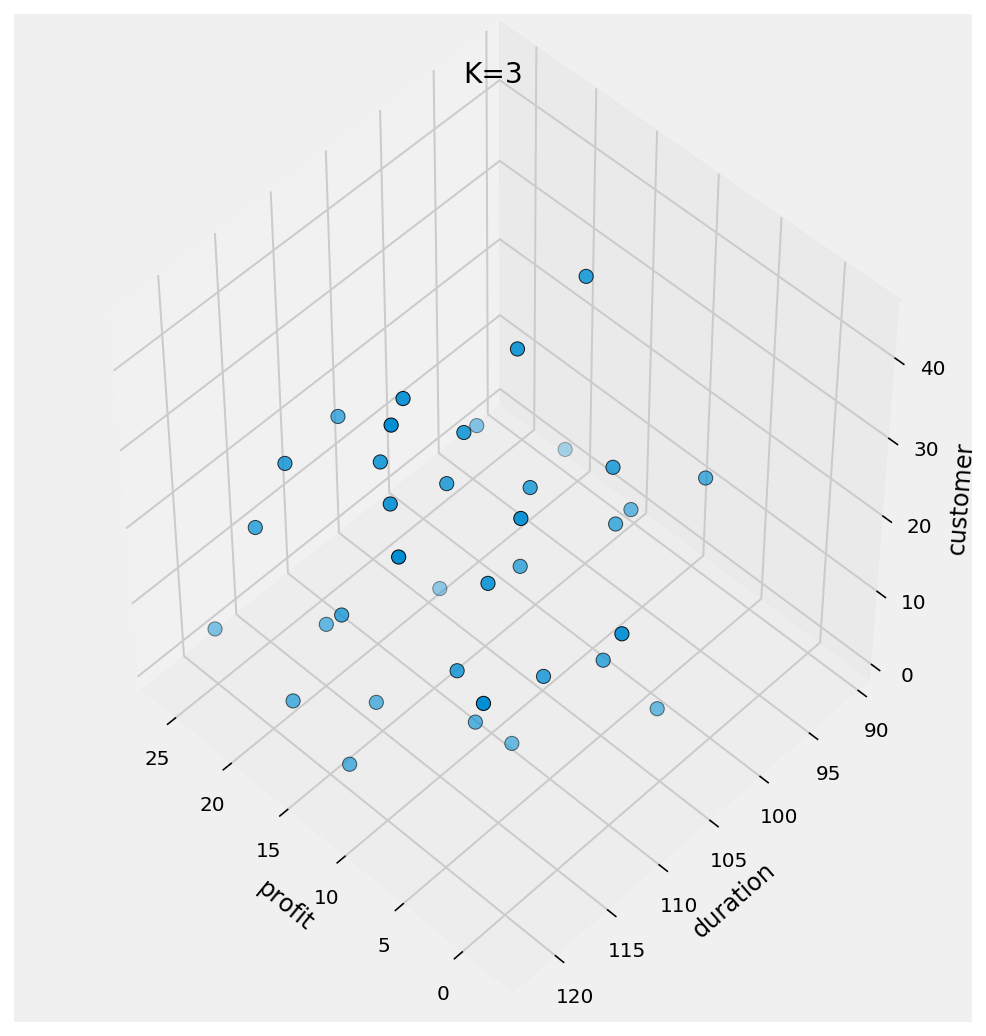

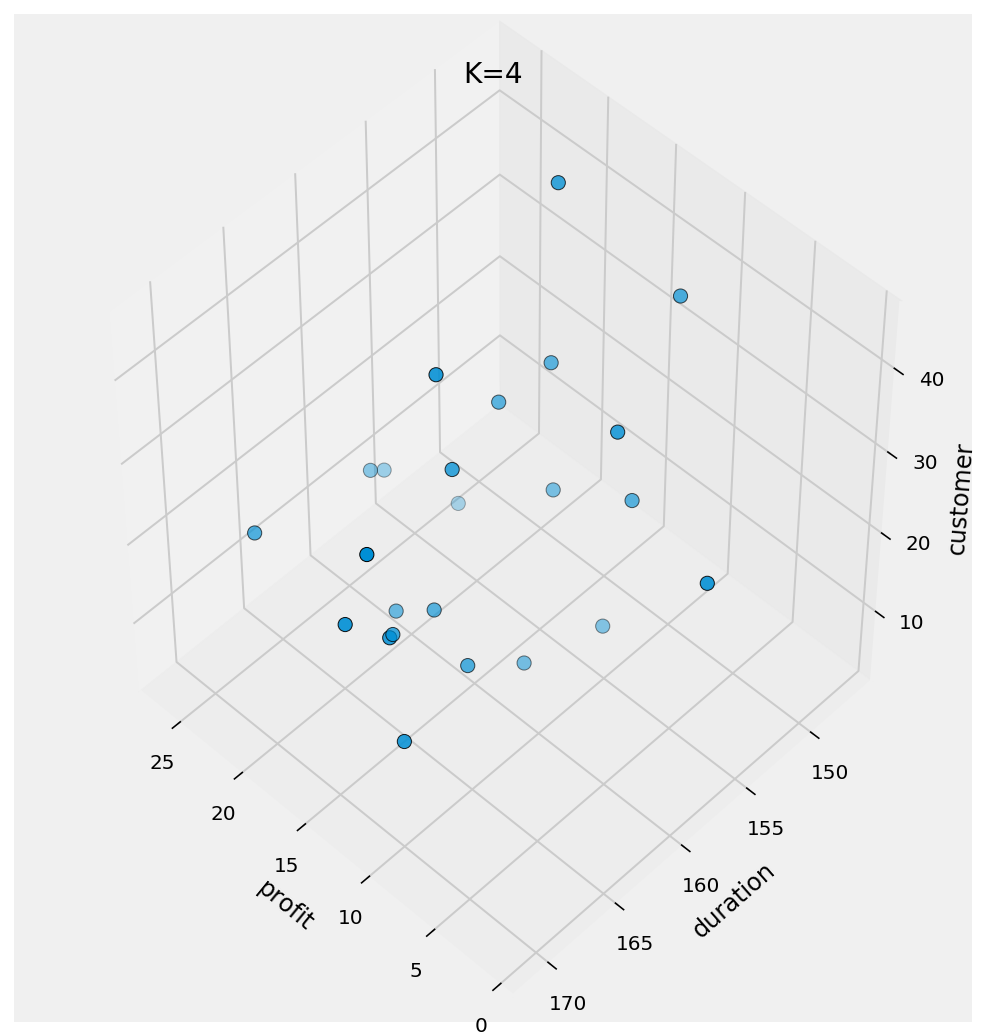

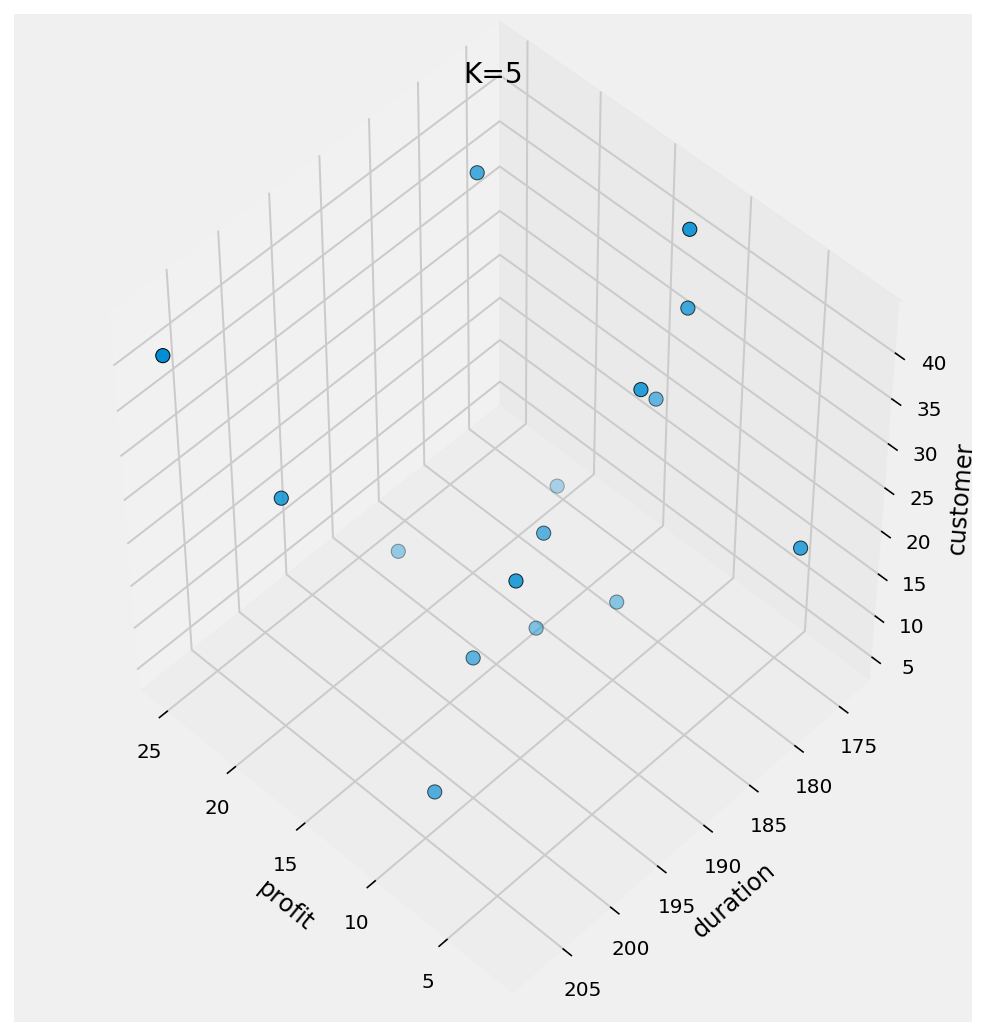

In [95]:
from mpl_toolkits.mplot3d import Axes3D

for k in xrange(K):
    fig = plt.figure(1, figsize=(7,7))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    ax.scatter(cluster[k]["profit"], cluster[k]["transitDuration"], cluster[k]["customer_id"],edgecolor="k", s=50)
    ax.set_xlabel("profit")
    ax.set_ylabel("duration")
    ax.set_zlabel("customer")
    plt.title("K=%d"%k, fontsize=14)
    plt.show()
